<a href="https://colab.research.google.com/github/hilmizr/thesis-yolo/blob/main/02_YOLO11n_%5BTHESIS%5DMasKris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [ ]:
!pip install ultralytics roboflow gdown thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


# Import Libraries

In [ ]:
import os
import shutil
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from IPython.display import display
from PIL import Image
import cv2
import json
from shutil import copyfile
import sys
import os
import requests
from pathlib import Path
import random
import pathlib

# Setup Custom YOLO

In [ ]:
from ultralytics import YOLO
from ultralytics.models import yolo

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Compile Model

In [ ]:
modif_model = YOLO("/content/yolo11n.pt")

# Setup Dataset

## Download Dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="e3DAOLcZTZkR7VlO5jY2")
project = rf.workspace("pcithesis").project("mkthesis-v4-kfvrb")
version = project.version(3)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to mkthesis-v4-3 in yolov11:: 100%|██████████| 7243/7243 [00:00<00:00, 9026.13it/s] 


In [ ]:
data_yaml_path="/content/mkthesis-v4-3/data.yaml"

# Modeling

In [ ]:
modif_model.train(
    data=data_yaml_path,
    epochs=300,

    # spatial / batch
    imgsz=640,            # will train on 640×640 images (3 channels assumed)
    batch=16,             # batch size

    # optimizer & LR schedule
    optimizer='SGD',      # stochastic gradient descent
    lr0=0.01,             # initial learning rate
    lrf=0.1,              # final learning rate factor (multiplied by lr0 at end of training)
    momentum=0.937,       # SGD momentum
    weight_decay=0.0005,  # L2 regularization factor

    # early stopping & checkpointing
    patience=10,
    save=True,
    save_period=-1,

    device=0
)

Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mkthesis-v4-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspective=0.0, plots=Tru

# Evaluate

## Assess GFLOPs, Parameters, and Size

In [ ]:
best_weights = '/content/runs/detect/train/weights/best.pt'
best_model   = YOLO(best_weights)
print("----- Detailed Model Summary (verbose) -----")
best_model.info(verbose=True)
size_bytes = os.path.getsize(best_weights)
size_mb    = size_bytes / (1024 ** 2)
print(f"Checkpoint file size: {size_mb:.2f} MB")

----- Detailed Model Summary (verbose) -----
YOLO11n summary: 181 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs
Checkpoint file size: 5.23 MB


In [ ]:
from thop import profile
import torch
best_model.model.to('cuda')
input = torch.randn(1, 3, 640, 640).to('cuda')
macs, params = profile(best_model.model, inputs=(input, ))
gflops = macs / 1e9
print(f"GFLOPs: {gflops:.2f}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
GFLOPs: 3.22


In [ ]:
# Save model summary
with open("model_summary.txt", "w") as f:
    f.write("----- Model Summary -----\n")
    f.write(f"Parameters: {params:,}\n")
    f.write(f"Checkpoint file size: {size_mb:.2f} MB\n")
    f.write(f"GFLOPs: {gflops:.2f}\n")

## Evaluate on Test Set

In [ ]:
test_results = best_model.val(
    data=data_yaml_path,
    split='test',
    batch=16,
    imgsz=640,
    save_json=True,
    save_txt=True,
    plots=True,
    verbose=True
)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 943.2±322.7 MB/s, size: 34.3 KB)
val: Scanning /content/mkthesis-v4-1/test/labels... 362 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 362/362 1.5Kit/s 0.2s
val: New cache created: /content/mkthesis-v4-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 1.9it/s 12.1s
                   all        362       1427      0.847      0.727      0.811      0.428
Speed: 1.2ms preprocess, 2.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving /content/runs/detect/val/predictions.json...
Results saved to /content/runs/detect/val


In [ ]:
precision = test_results.box.mp
recall = test_results.box.mr
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

In [ ]:
# Print key metrics
print(f"Test mAP50: {test_results.box.map50:.4f}")
print(f"Test mAP50-95: {test_results.box.map:.4f}")
print(f"Test mAP75: {test_results.box.map75:.4f}")
print(f"Test Precision: {test_results.box.mp:.4f}")
print(f"Test Recall: {test_results.box.mr:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Test mAP50: 0.8108
Test mAP50-95: 0.4277
Test mAP75: 0.4097
Test Precision: 0.8474
Test Recall: 0.7267
Test F1 Score: 0.7824


In [ ]:
# Save test metrics
with open("test_metrics.txt", "w") as f:
    f.write("----- Test Metrics -----\n")
    f.write(f"Test mAP50: {test_results.box.map50:.4f}\n")
    f.write(f"Test mAP75: {test_results.box.map75:.4f}\n")
    f.write(f"Test mAP50-95: {test_results.box.map:.4f}\n")
    f.write(f"Test Precision: {test_results.box.mp:.4f}\n")
    f.write(f"Test Recall: {test_results.box.mr:.4f}\n")
    f.write(f"Test F1 Score: {f1_score:.4f}\n")

## Export Confusion Matrices as CSV

In [ ]:
cm_test = test_results.confusion_matrix.matrix
np.savetxt("cm_test.csv", cm_test, delimiter=",", fmt="%.0f")

## Export Per-Class Metrics

In [ ]:
# ---- Export Per-Class Metrics ----
num_classes = len(test_results.box.p)
per_class_metrics = pd.DataFrame({
    "Class ID": np.arange(num_classes),
    "Class Name": [best_model.names[i] for i in range(num_classes)],
    "Precision": test_results.box.p,
    "Recall": test_results.box.r,
    "F1 Score": test_results.box.f1,
    "AP50": test_results.box.ap50,
    "AP50-95": test_results.box.ap
})
per_class_metrics.to_csv("per_class_metrics.csv", index=False)
print("✅ Exported per_class_metrics.csv")

✅ Exported per_class_metrics.csv


## Plot LR Progression Against Loss & mAP

In [ ]:
results_csv = Path('/content/runs/detect/train/results.csv')
df = pd.read_csv(results_csv)
print(df.columns)

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


In [ ]:
df

epoch       time  train/box_loss  train/cls_loss  train/dfl_loss  \
0        1    50.3367         2.41629         3.30538         1.80035   
1        2    71.7777         2.23907         2.36799         1.64063   
2        3    92.9693         2.28107         2.24790         1.54972   
3        4   113.9090         2.23461         2.18989         1.55838   
4        5   134.8560         2.22942         2.05485         1.54011   
..     ...        ...             ...             ...             ...   
117    118  2451.5100         1.52900         0.88247         1.14884   
118    119  2471.9300         1.53644         0.88506         1.14544   
119    120  2492.1400         1.53221         0.87045         1.13796   
120    121  2512.5700         1.55138         0.89664         1.15301   
121    122  2533.2000         1.52013         0.87227         1.13574   

     metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0                 0.35261            0.25284           0.20661   
1                 0.37324            0.25115           0.22252   
2                 0.39256            0.26281           0.22964   
3                 0.45745            0.37039           0.33612   
4                 0.45831            0.37564           0.34236   
..                    ...                ...               ...   
117               0.85300            0.72996           0.81314   
118               0.85540            0.73478           0.81363   
119               0.84223            0.72167           0.80998   
120               0.85378            0.72310           0.81240   
121               0.84652            0.72858           0.81277   

     metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0                0.07163       2.18498       2.44726       1.71935  0.070189   
1                0.07924       2.21101       2.36177       1.62917  0.040169   
2                0.07508       2.23361       3.22162       1.60870  0.010129   
3                0.11820       2.17627       3.19019       1.59400  0.009910   
4                0.11587       2.23509       2.26761       1.67234  0.009880   
..                   ...           ...           ...           ...       ...   
117              0.41970       1.61795       0.81981       1.24582  0.006490   
118              0.42472       1.60607       0.82110       1.23802  0.006460   
119              0.42061       1.60960       0.83468       1.23260  0.006430   
120              0.41865       1.60229       0.83459       1.23063  0.006400   
121              0.42579       1.60288       0.81359       1.23722  0.006370   

       lr/pg1    lr/pg2  
0    0.003312  0.003312  
1    0.006626  0.006626  
2    0.009919  0.009919  
3    0.009910  0.009910  
4    0.009880  0.009880  
..        ...       ...  
117  0.006490  0.006490  
118  0.006460  0.006460  
119  0.006430  0.006430  
120  0.006400  0.006400  
121  0.006370  0.006370  

[122 rows x 15 columns]

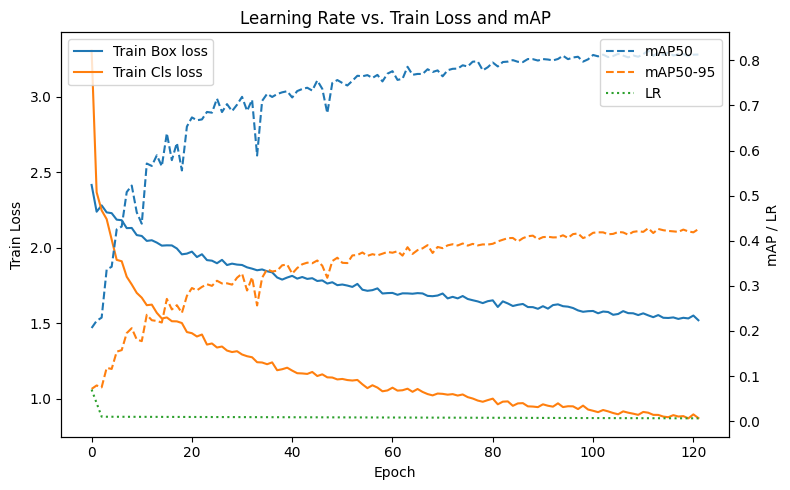

In [ ]:
# ===== Plot 1: Train Loss, mAP, LR =====
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot training losses
ax1.plot(df.index, df['train/box_loss'], label='Train Box loss')
ax1.plot(df.index, df['train/cls_loss'], label='Train Cls loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss')
ax1.legend(loc='upper left')

# Twin axis for mAP and LR
ax2 = ax1.twinx()
ax2.plot(df.index, df['metrics/mAP50(B)'], '--', label='mAP50')
ax2.plot(df.index, df['metrics/mAP50-95(B)'], '--', label='mAP50-95')
ax2.plot(df.index, df['lr/pg0'], ':', label='LR')
ax2.set_ylabel('mAP / LR')
ax2.legend(loc='upper right')

plt.title('Learning Rate vs. Train Loss and mAP')
plt.tight_layout()
plt.savefig('train_loss_vs_map_lr.png', dpi=300)
plt.show()  # Show plot 1

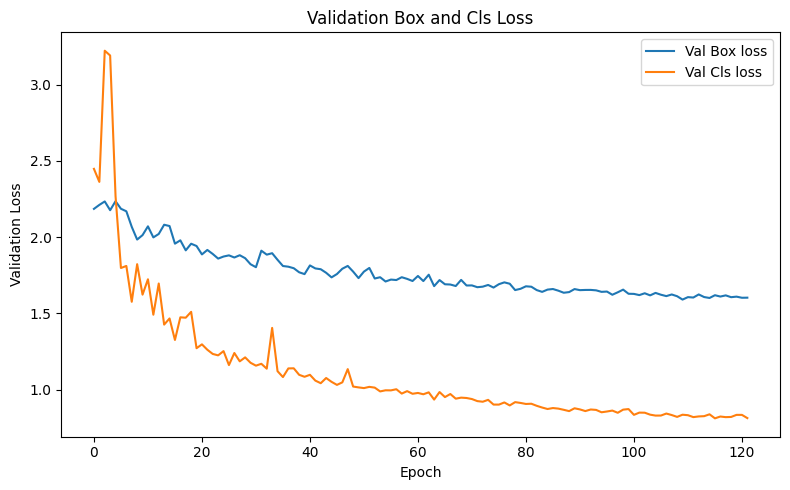

In [ ]:
# ===== Plot 2: Validation Losses =====
fig2, ax = plt.subplots(figsize=(8, 5))
ax.plot(df.index, df['val/box_loss'], label='Val Box loss')
ax.plot(df.index, df['val/cls_loss'], label='Val Cls loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.legend()
plt.title('Validation Box and Cls Loss')
plt.tight_layout()
plt.savefig('val_loss.png', dpi=300)
plt.show()  # Show plot 2

## Visualize Sample Object Detection

In [ ]:
test_folder = "/content/mkthesis-v4-1/test/images"


image 1/1 /content/mkthesis-v4-1/test/images/00002511_jpg.rf.b931aaffd78afa372c2fd7dfa5440b2f.jpg: 640x640 1 Thesis - v4 2024-04-16 3-34pm, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


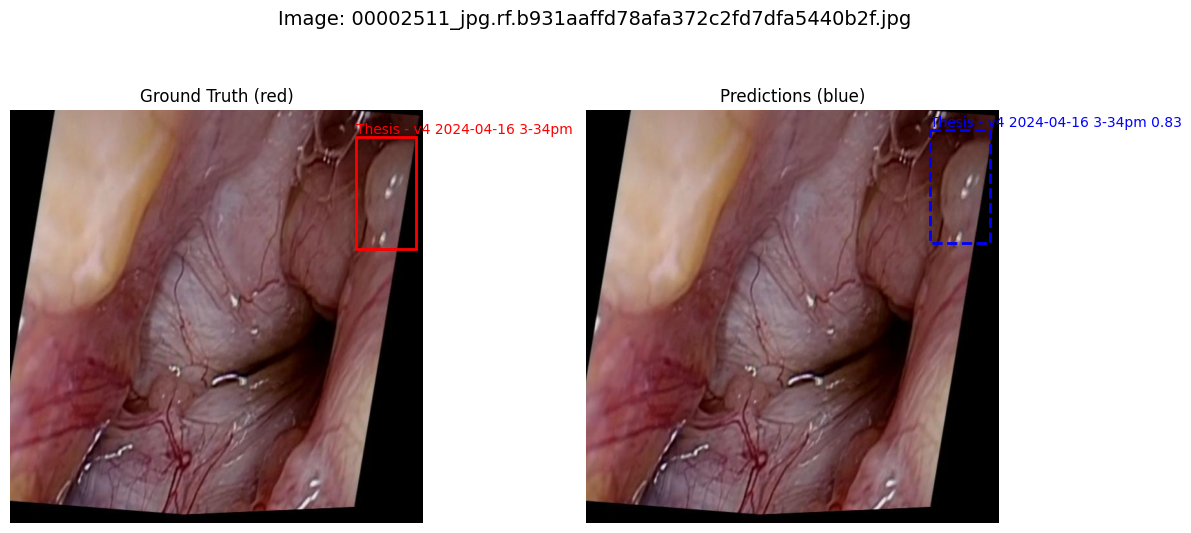


image 1/1 /content/mkthesis-v4-1/test/images/44a6b7e8-d89f-42dc-9854-2f36e8968cad_jpeg.rf.d085fab055fed529f9341c8100ccba6d.jpg: 640x640 3 Thesis - v4 2024-04-16 3-34pms, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


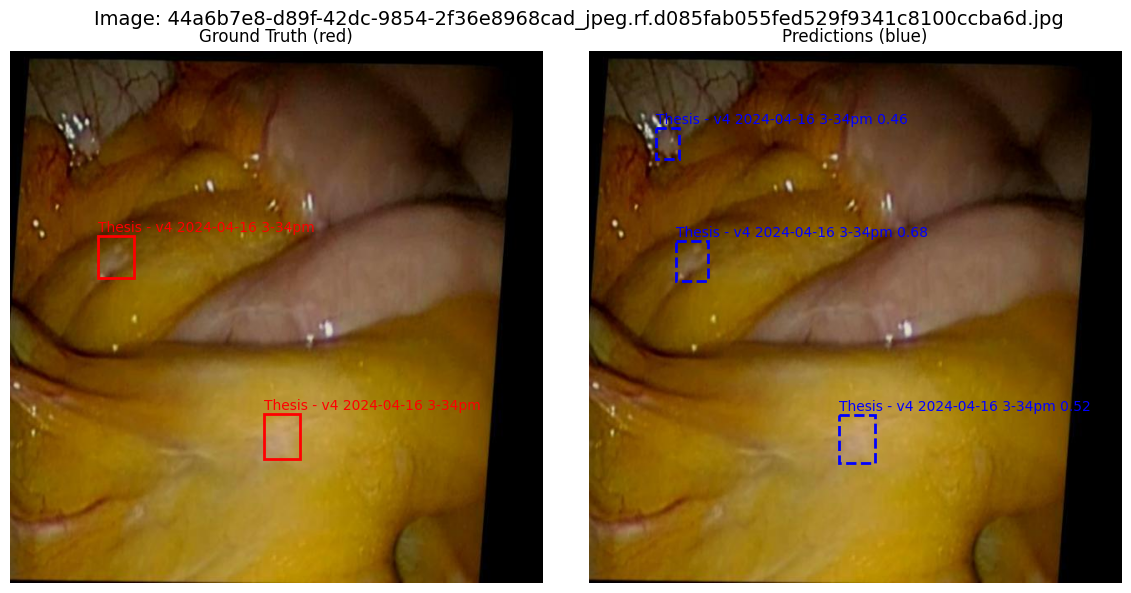


image 1/1 /content/mkthesis-v4-1/test/images/00000348_jpg.rf.db009220967598531924a2ab5f2246b1.jpg: 640x640 1 Thesis - v4 2024-04-16 3-34pm, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


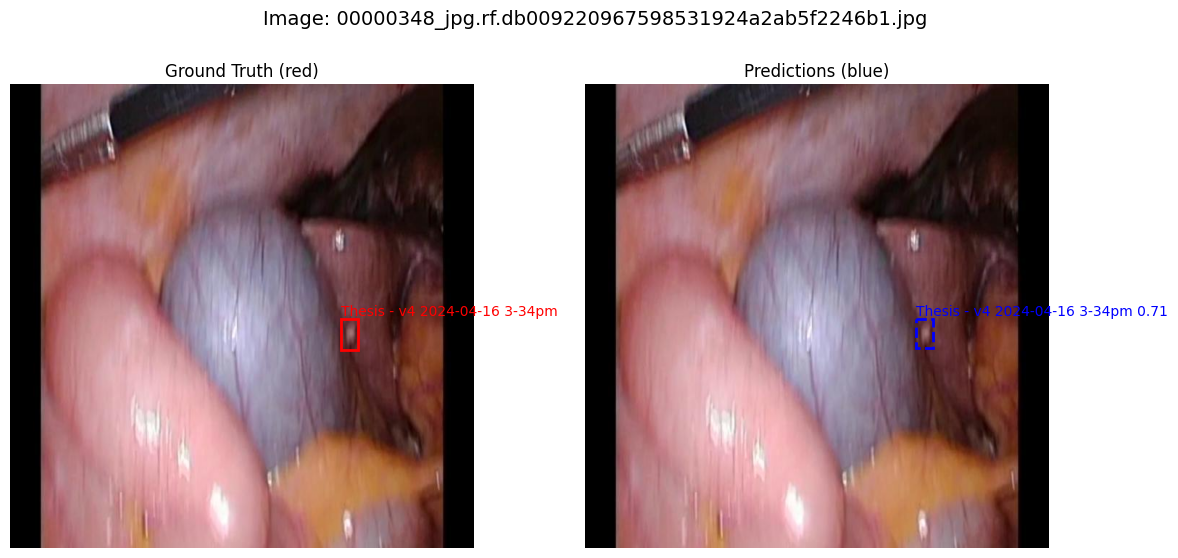


image 1/1 /content/mkthesis-v4-1/test/images/00002070_jpg.rf.513296c6e311e1fc2bc76793be22a101.jpg: 640x640 7 Thesis - v4 2024-04-16 3-34pms, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


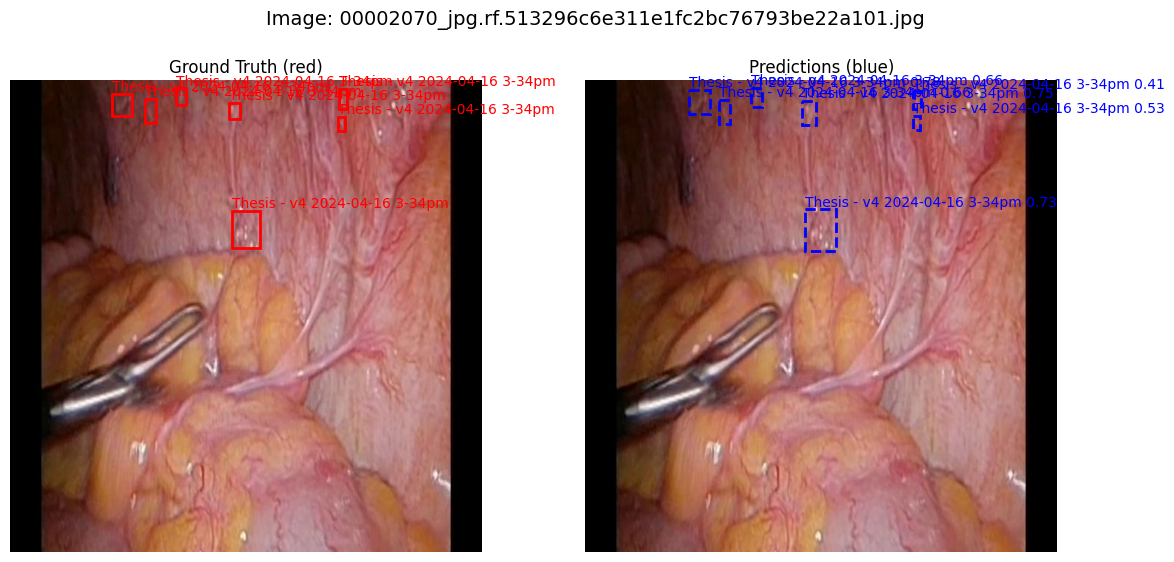


image 1/1 /content/mkthesis-v4-1/test/images/5eb043f8-be20-4bdb-abbc-f4c35c8fc406_jpeg.rf.4c78d261de8d09d1919c418cc43385e3.jpg: 640x640 2 Thesis - v4 2024-04-16 3-34pms, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


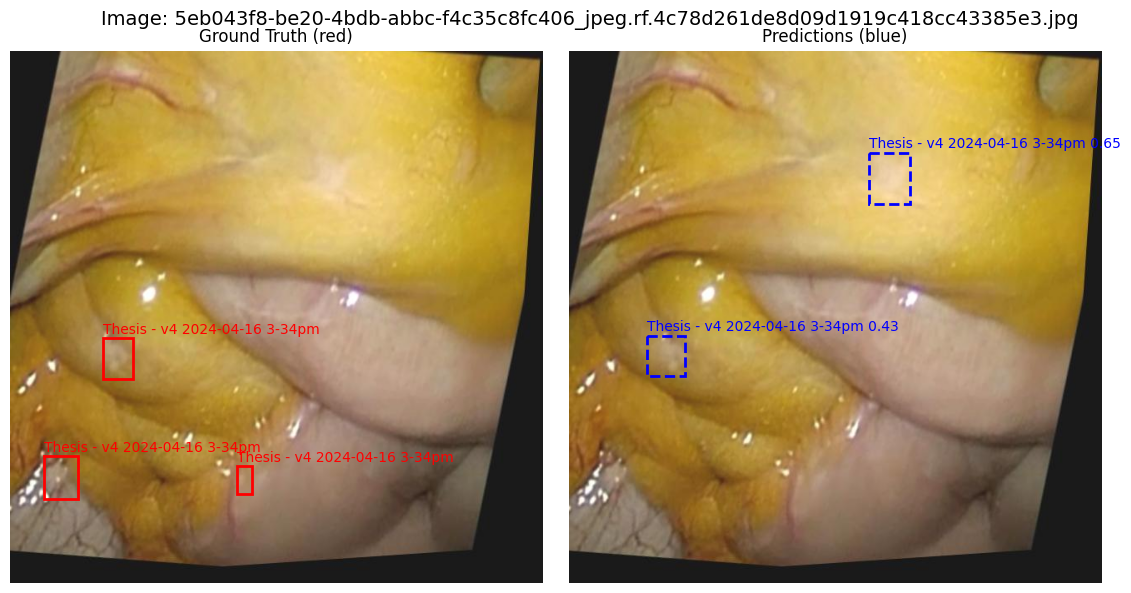

In [ ]:
test_images_dir = pathlib.Path(test_folder)
test_labels_dir = test_images_dir.parent / 'labels'

all_test_images = list(test_images_dir.glob('*.jpg')) + list(test_images_dir.glob('*.png'))
if not all_test_images:
    raise RuntimeError(f"No images found in {test_images_dir}")

N = 5
sample_images = random.sample(all_test_images, k=min(N, len(all_test_images)))

for img_path in sample_images:
    img     = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    results = best_model.predict(source=str(img_path), conf=0.25)
    preds   = results[0].boxes  # .boxes.xyxy, .boxes.cls, .boxes.conf

    label_file = test_labels_dir / f"{img_path.stem}.txt"
    gt_boxes = []
    if label_file.exists():
        with open(label_file, 'r') as f:
            for line in f:
                toks = line.split()
                if len(toks) < 5:
                    continue
                cls_id   = int(float(toks[0]))
                x_center = float(toks[1])
                y_center = float(toks[2])
                bw       = float(toks[3])
                bh       = float(toks[4])
                x_min = (x_center - bw / 2) * w
                y_min = (y_center - bh / 2) * h
                x_max = (x_center + bw / 2) * w
                y_max = (y_center + bh / 2) * h
                gt_boxes.append((int(x_min), int(y_min), int(x_max), int(y_max), cls_id))
    else:
        print(f"⚠️ Warning: No label file for {img_path.name}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax_gt, ax_pred = axes[0], axes[1]

    ax_gt.imshow(img_rgb)
    ax_gt.set_title("Ground Truth (red)")
    ax_gt.axis('off')
    for (xmin, ymin, xmax, ymax, cls_id) in gt_boxes:
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='red',
            facecolor='none',
            linestyle='-'
        )
        ax_gt.add_patch(rect)
        ax_gt.text(
            xmin,
            ymin - 5,
            f"{best_model.names[cls_id]}",
            color='red',
            fontsize=10
        )

    ax_pred.imshow(img_rgb)
    ax_pred.set_title("Predictions (blue)")
    ax_pred.axis('off')
    for box in preds:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        cls_id = int(box.cls.cpu().numpy()[0])
        conf   = float(box.conf.cpu().numpy()[0])
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor='blue',
            facecolor='none',
            linestyle='--'
        )
        ax_pred.add_patch(rect)
        ax_pred.text(
            x1,
            y1 - 5,
            f"{best_model.names[cls_id]} {conf:.2f}",
            color='blue',
            fontsize=10
        )

    plt.suptitle(f"Image: {img_path.name}", fontsize=14)
    plt.tight_layout()
    plt.show()



image 1/1 /content/mkthesis-v4-1/test/images/00000410_jpg.rf.69f00443d4beb8bbdd4508e9ded796de.jpg: 640x640 1 Thesis - v4 2024-04-16 3-34pm, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


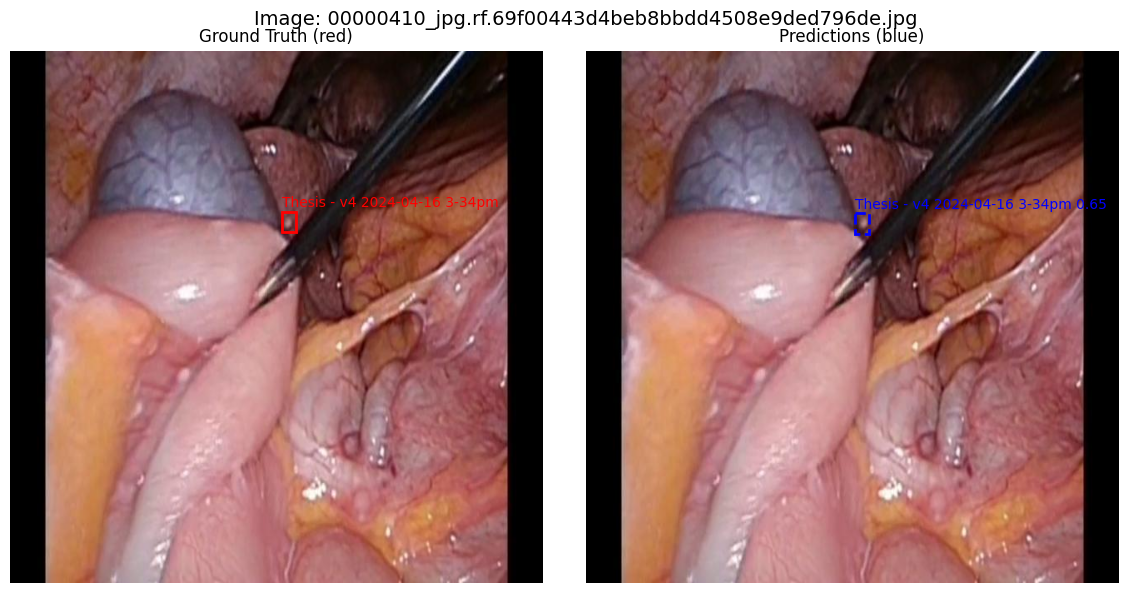


image 1/1 /content/mkthesis-v4-1/test/images/473f2641-2025-41d5-ba62-aae86e63da28_jpeg.rf.54044b0c511482861ab572117ad3b531.jpg: 640x640 3 Thesis - v4 2024-04-16 3-34pms, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


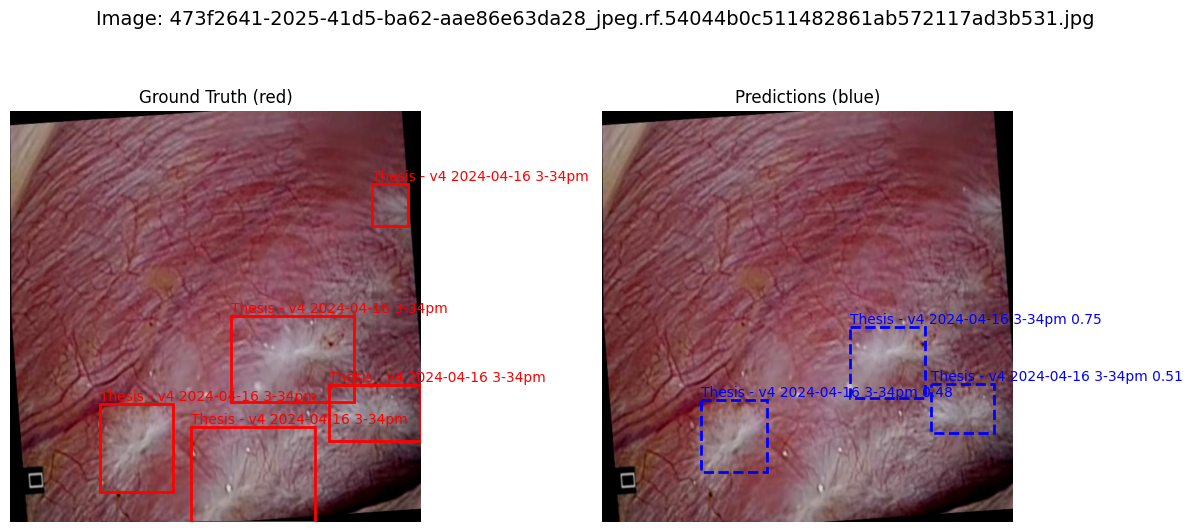


image 1/1 /content/mkthesis-v4-1/test/images/00000255_jpg.rf.ae5e184f0372a49be94ae0009f0576bc.jpg: 640x640 1 Thesis - v4 2024-04-16 3-34pm, 9.6ms
Speed: 1.7ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


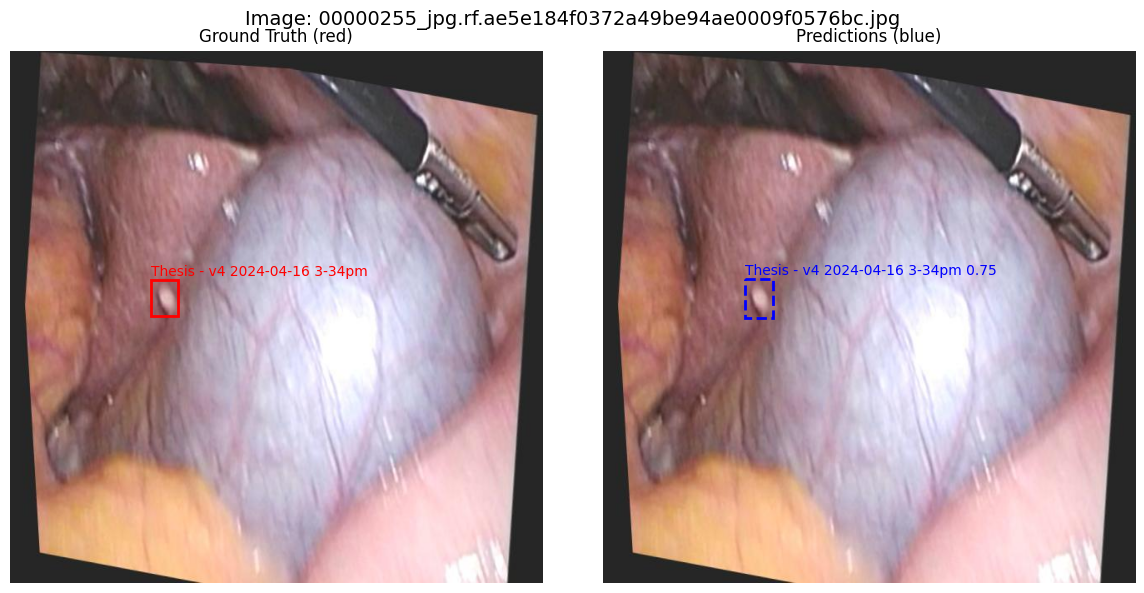


image 1/1 /content/mkthesis-v4-1/test/images/00002067_jpg.rf.621b15ee6758f9390f9e365be7a7b0c0.jpg: 640x640 7 Thesis - v4 2024-04-16 3-34pms, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


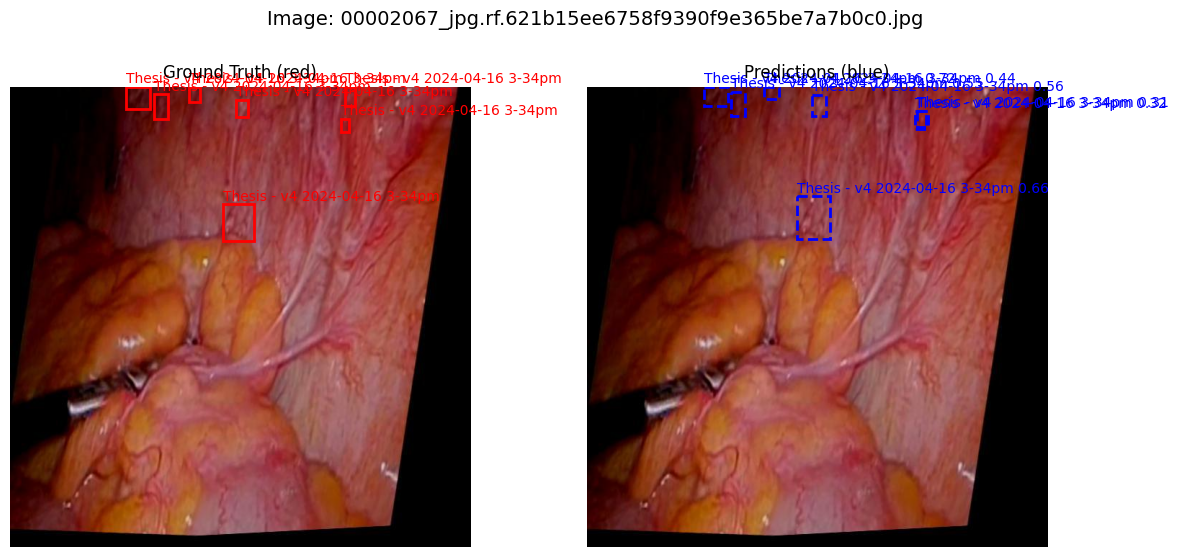


image 1/1 /content/mkthesis-v4-1/test/images/00003149_jpg.rf.f3c7d1f054603b6d2213b086a4f5114f.jpg: 640x640 3 Thesis - v4 2024-04-16 3-34pms, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


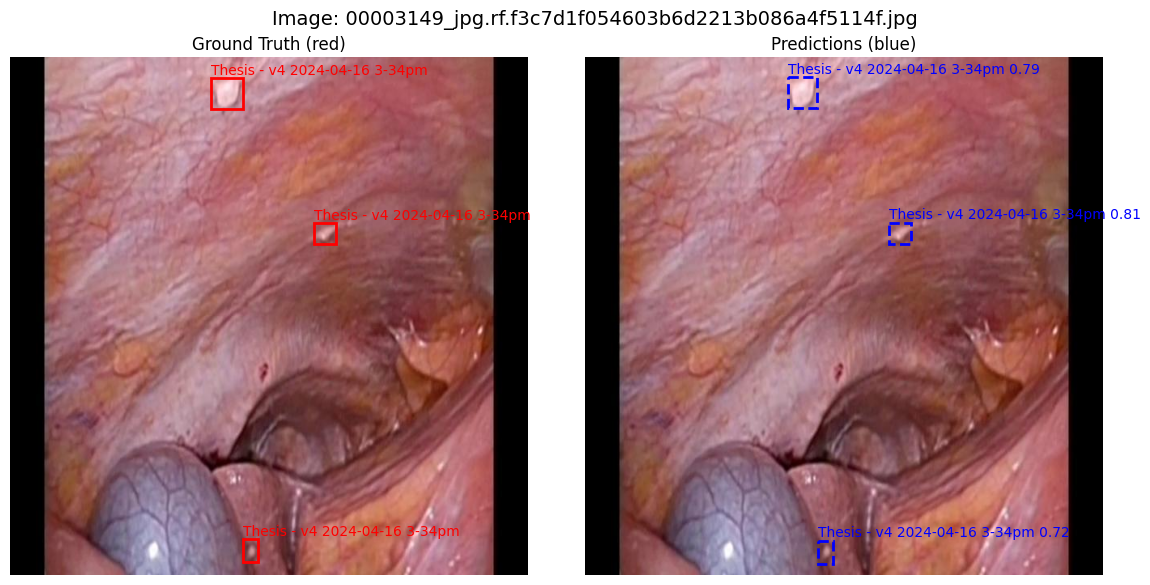

In [ ]:
output_dir = Path("sample_visualizations")
output_dir.mkdir(parents=True, exist_ok=True)

N = 5
sample_images = random.sample(all_test_images, k=min(N, len(all_test_images)))

for img_path in sample_images:
    img     = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    results = best_model.predict(source=str(img_path), conf=0.25)
    preds   = results[0].boxes

    label_file = test_labels_dir / f"{img_path.stem}.txt"
    gt_boxes = []
    if label_file.exists():
        with open(label_file, 'r') as f:
            for line in f:
                toks = line.split()
                if len(toks) < 5:
                    continue
                cls_id   = int(float(toks[0]))
                x_center = float(toks[1])
                y_center = float(toks[2])
                bw       = float(toks[3])
                bh       = float(toks[4])
                x_min = (x_center - bw / 2) * w
                y_min = (y_center - bh / 2) * h
                x_max = (x_center + bw / 2) * w
                y_max = (y_center + bh / 2) * h
                gt_boxes.append((int(x_min), int(y_min), int(x_max), int(y_max), cls_id))
    else:
        print(f"⚠️ Warning: No label file for {img_path.name}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax_gt, ax_pred = axes[0], axes[1]

    ax_gt.imshow(img_rgb)
    ax_gt.set_title("Ground Truth (red)")
    ax_gt.axis('off')
    for (xmin, ymin, xmax, ymax, cls_id) in gt_boxes:
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax_gt.add_patch(rect)
        ax_gt.text(xmin, ymin - 5, f"{best_model.names[cls_id]}", color='red', fontsize=10)

    ax_pred.imshow(img_rgb)
    ax_pred.set_title("Predictions (blue)")
    ax_pred.axis('off')
    for box in preds:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        cls_id = int(box.cls.cpu().numpy()[0])
        conf   = float(box.conf.cpu().numpy()[0])
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='blue', facecolor='none', linestyle='--')
        ax_pred.add_patch(rect)
        ax_pred.text(x1, y1 - 5, f"{best_model.names[cls_id]} {conf:.2f}", color='blue', fontsize=10)

    plt.suptitle(f"Image: {img_path.name}", fontsize=14)
    plt.tight_layout()

    # ✅ Save the figure
    output_path = output_dir / f"{img_path.stem}_gt_vs_pred.png"
    plt.savefig(output_path, dpi=300)
    plt.show()


## Export Prediction Results as CSV

In [ ]:
# ---- Export Prediction Results ----
prediction_data = []
for img_path in all_test_images:
    results = best_model.predict(source=str(img_path), conf=0.25)
    preds = results[0].boxes
    for box in preds:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        cls_id = int(box.cls.cpu().numpy()[0])
        conf = float(box.conf.cpu().numpy()[0])
        prediction_data.append({
            "Image": img_path.name,
            "Class ID": cls_id,
            "Class Name": best_model.names[cls_id],
            "Confidence": conf,
            "X1": x1,
            "Y1": y1,
            "X2": x2,
            "Y2": y2
        })
df_preds = pd.DataFrame(prediction_data)
df_preds.to_csv("prediction_results.csv", index=False)
print("✅ Exported prediction_results.csv")


image 1/1 /content/mkthesis-v4-1/test/images/00000777_jpg.rf.350b6c221d908d9b075bbc12635dca80.jpg: 640x640 14 Thesis - v4 2024-04-16 3-34pms, 12.7ms
Speed: 2.7ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/mkthesis-v4-1/test/images/00000643_jpg.rf.6fe164db51ddef4c66ed44a68aa5e8bf.jpg: 640x640 3 Thesis - v4 2024-04-16 3-34pms, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/mkthesis-v4-1/test/images/00002411_jpg.rf.560a48a079298346721b61e61ca61ca5.jpg: 640x640 1 Thesis - v4 2024-04-16 3-34pm, 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/mkthesis-v4-1/test/images/00001455_jpg.rf.88e75c352b7d9aeae44ea2da03b0e44f.jpg: 640x640 5 Thesis - v4 2024-04-16 3-34pms, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/mk

In [ ]:
import datetime
from zipfile import ZipFile
import shutil
import os
from pathlib import Path
from google.colab import drive

DATASET_TYPE = "MKThesis-1"
model_name = "yolo11n"
yaml_path = "/content/mkthesis-v4-1/data.yaml"

# === Define dynamic export folder name based on YAML + timestamp ===
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
clean_dataset = DATASET_TYPE.replace(" ", "_")
export_name = f"{model_name}_{clean_dataset}_{timestamp}"
export_dir = Path(export_name)
export_dir.mkdir(parents=True, exist_ok=True)

# === List of files to export ===
export_files = [
    "cm_test.csv",
    "per_class_metrics.csv",
    "train_loss_vs_map_lr.png",
    "val_loss.png",
    "model_summary.txt",
    "test_metrics.txt",
    "prediction_results.csv",
    yaml_path
]
# === Copy export files into the export folder ===
for file in export_files:
    src = Path(file)
    dst = export_dir / f"{src.stem}_{export_name}{src.suffix}"
    shutil.copy(src, dst)

# === Copy best.pt and last.pt directly to the root of export folder ===
weights_dir = Path("/content/runs/detect/train/weights")
for weight_name in ["best.pt", "last.pt"]:
    weight_path = weights_dir / weight_name
    if weight_path.exists():
        weight_stem = Path(weight_name).stem
        weight_suffix = Path(weight_name).suffix
        renamed = f"{weight_stem}_{export_name}{weight_suffix}"
        shutil.copy(weight_path, export_dir / renamed)

# === Copy sample visualizations ===
sample_vis_dir = Path("sample_visualizations")
sample_vis_export = export_dir / f"sample_visualizations_{export_name}"
shutil.copytree(sample_vis_dir, sample_vis_export)

# === Copy HaYOLO runs/detect directory ===
detect_src = Path("/content/runs/detect")
detect_dst = export_dir / f"detect_outputs_{export_name}"
shutil.copytree(detect_src, detect_dst)

# === Zip the export directory ===
zip_filename = f"{export_name}.zip"
shutil.make_archive(base_name=export_name, format='zip', root_dir=export_dir)
print(f"✅ Zipped everything into {zip_filename}")

✅ Zipped everything into yolo11n_MKThesis-1_2025-11-10_04-57-56.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === Mount Google Drive and copy the zip file ===
try:
    # Create the ThesisYOLO folder if it doesn't exist
    thesis_yolo_folder = Path('/content/drive/MyDrive/ThesisYOLO')
    thesis_yolo_folder.mkdir(parents=True, exist_ok=True)
    drive_path = thesis_yolo_folder / zip_filename
    shutil.copy(zip_filename, drive_path)
    print(f"✅ Copied {zip_filename} to Google Drive: {drive_path}")
except Exception as e:
    print(f"❌ Failed to copy to Google Drive: {e}")

✅ Copied yolo11n_MKThesis-1_2025-11-10_04-57-56.zip to Google Drive: /content/drive/MyDrive/ThesisYOLO/yolo11n_MKThesis-1_2025-11-10_04-57-56.zip
